# JHU cross-country viz 

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "anytime"    TRUE  
 [5,] "lubridate"  TRUE  
 [6,] "plotly"     TRUE  
 [7,] "zoo"        TRUE  
 [8,] "patchwork"  TRUE  
 [9,] "ggrepel"    TRUE  


In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 27,930
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33…
$ Long           <dbl> 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "jhu_panel.csv")

# Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region,date,cases,deaths
<chr>,<date>,<int>,<int>
US,2020-05-05,1204351,71064
Spain,2020-05-05,219329,25613
Italy,2020-05-05,213013,29315
United Kingdom,2020-05-05,196243,29501
France,2020-05-05,170687,25537
Germany,2020-05-05,167007,6993
Russia,2020-05-05,155370,1451
Turkey,2020-05-05,129491,3520
Brazil,2020-05-05,115455,7938


In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

# Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 310 rows containing missing values (geom_point).”
Warning message:
“Removed 344 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 376 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 313 rows 

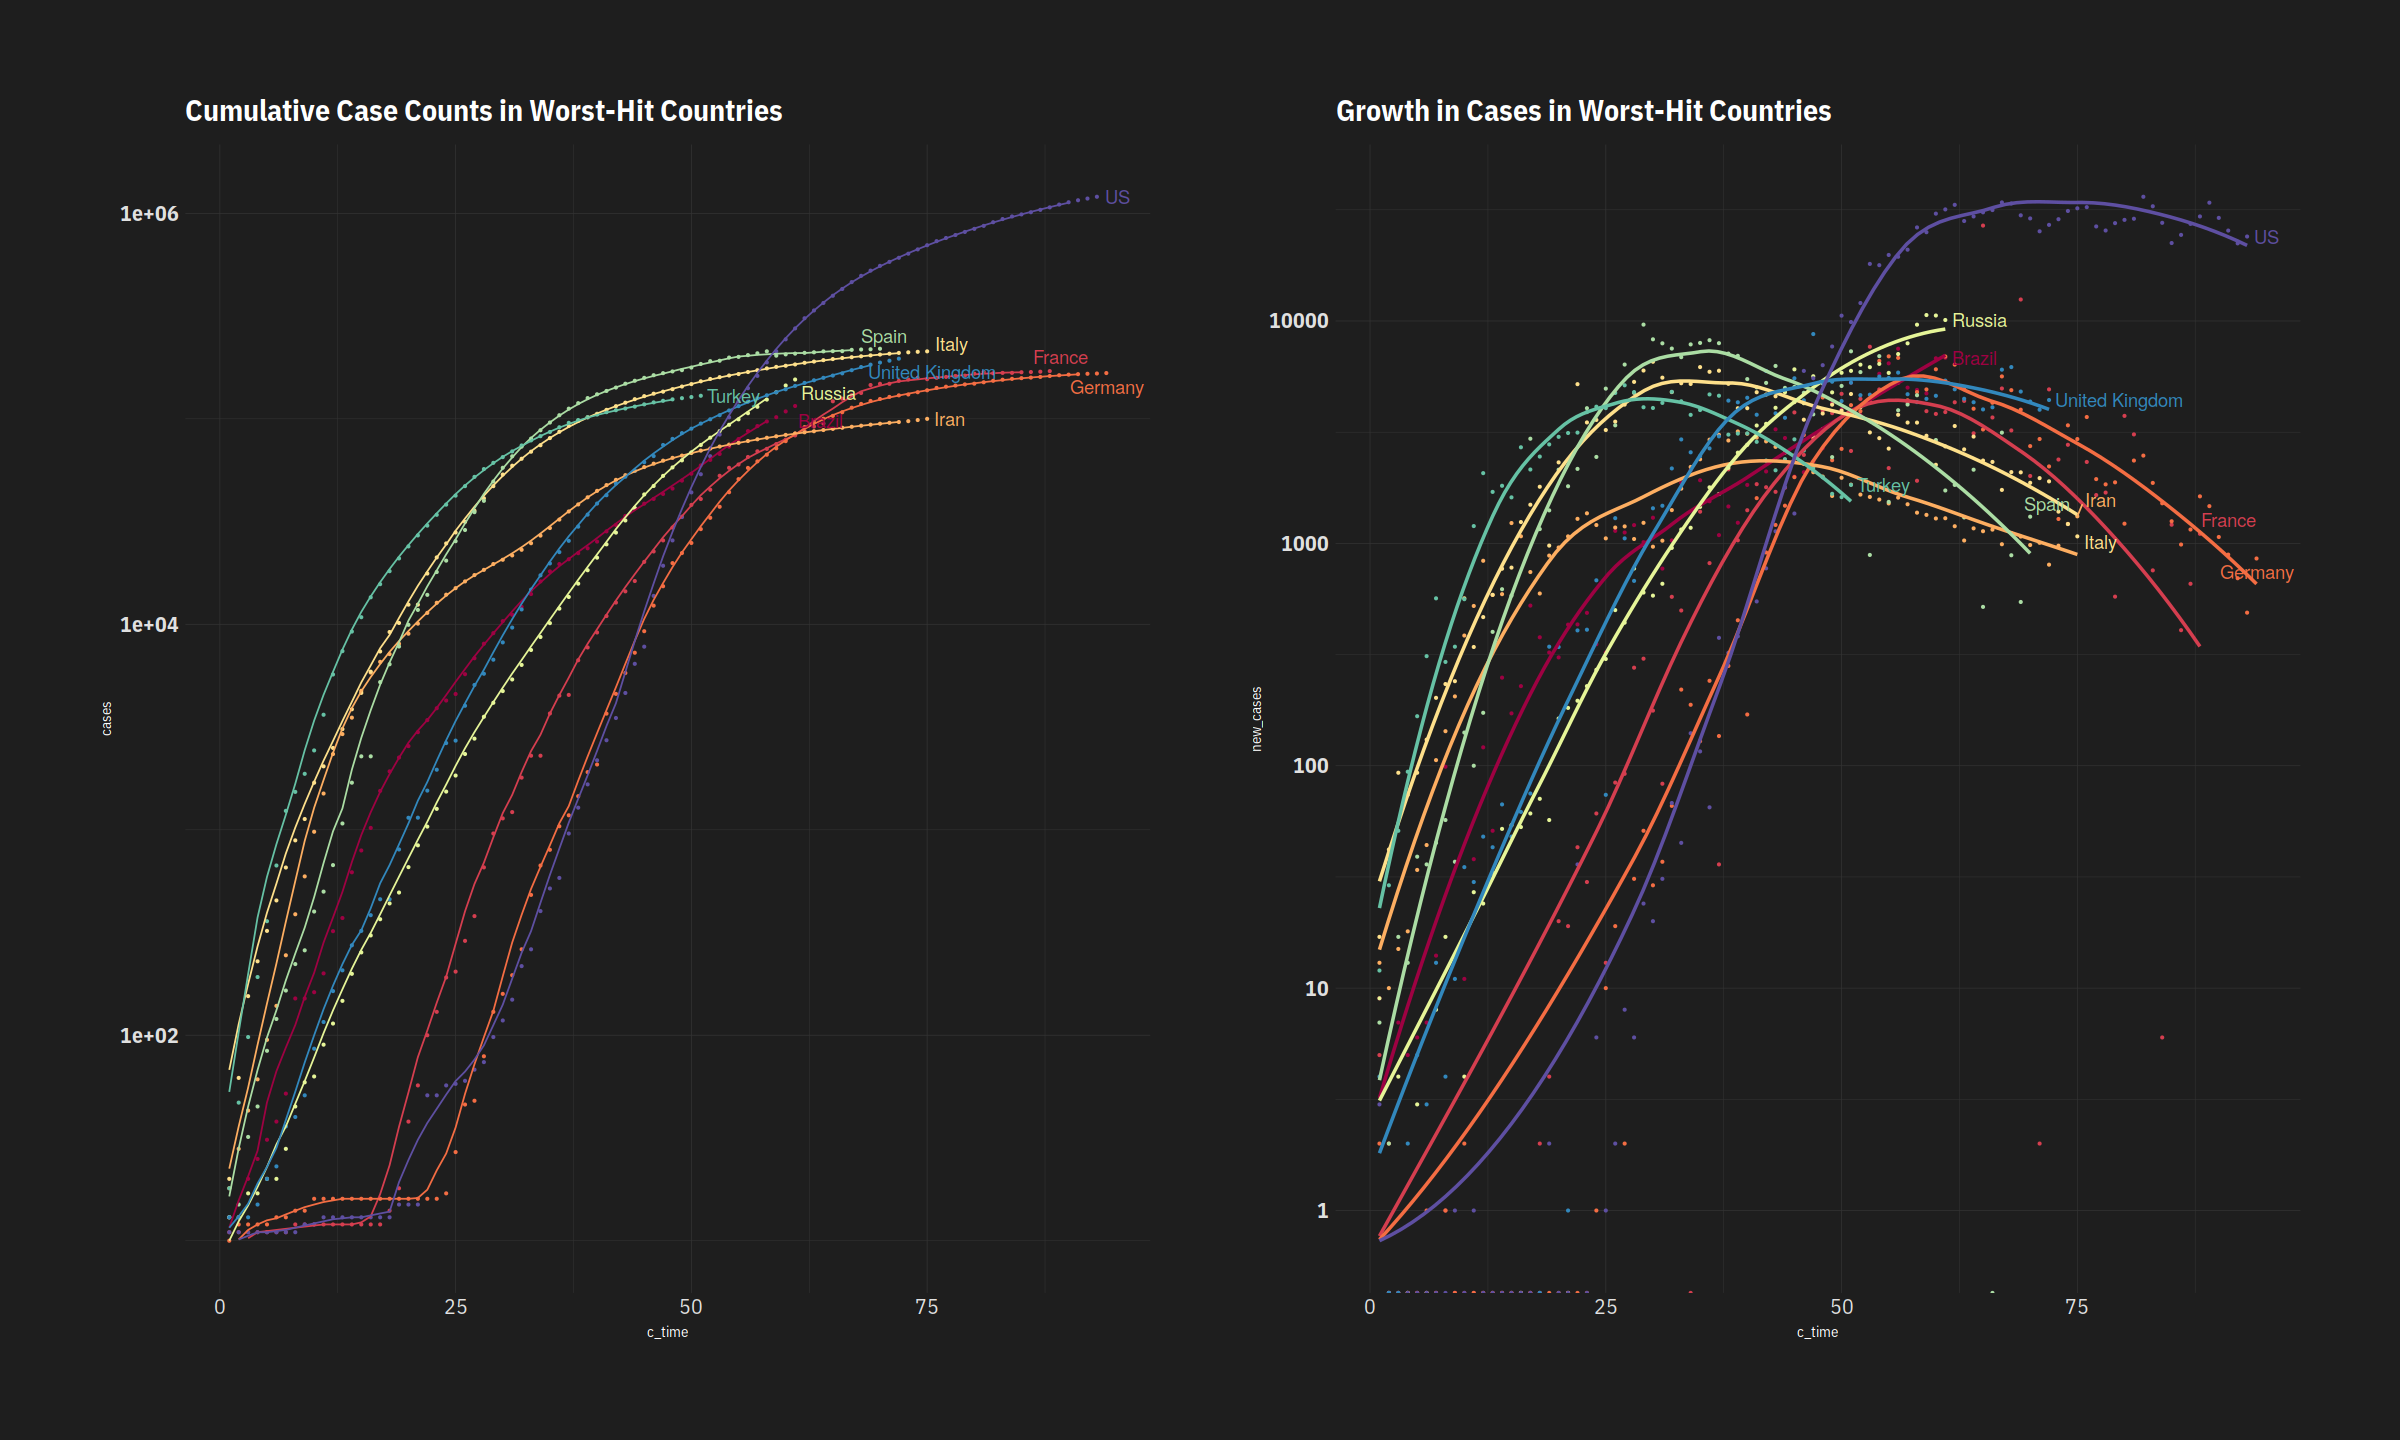

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 490 rows containing missing values (geom_point).”
Warning message:
“Removed 515 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 457 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 420 rows 

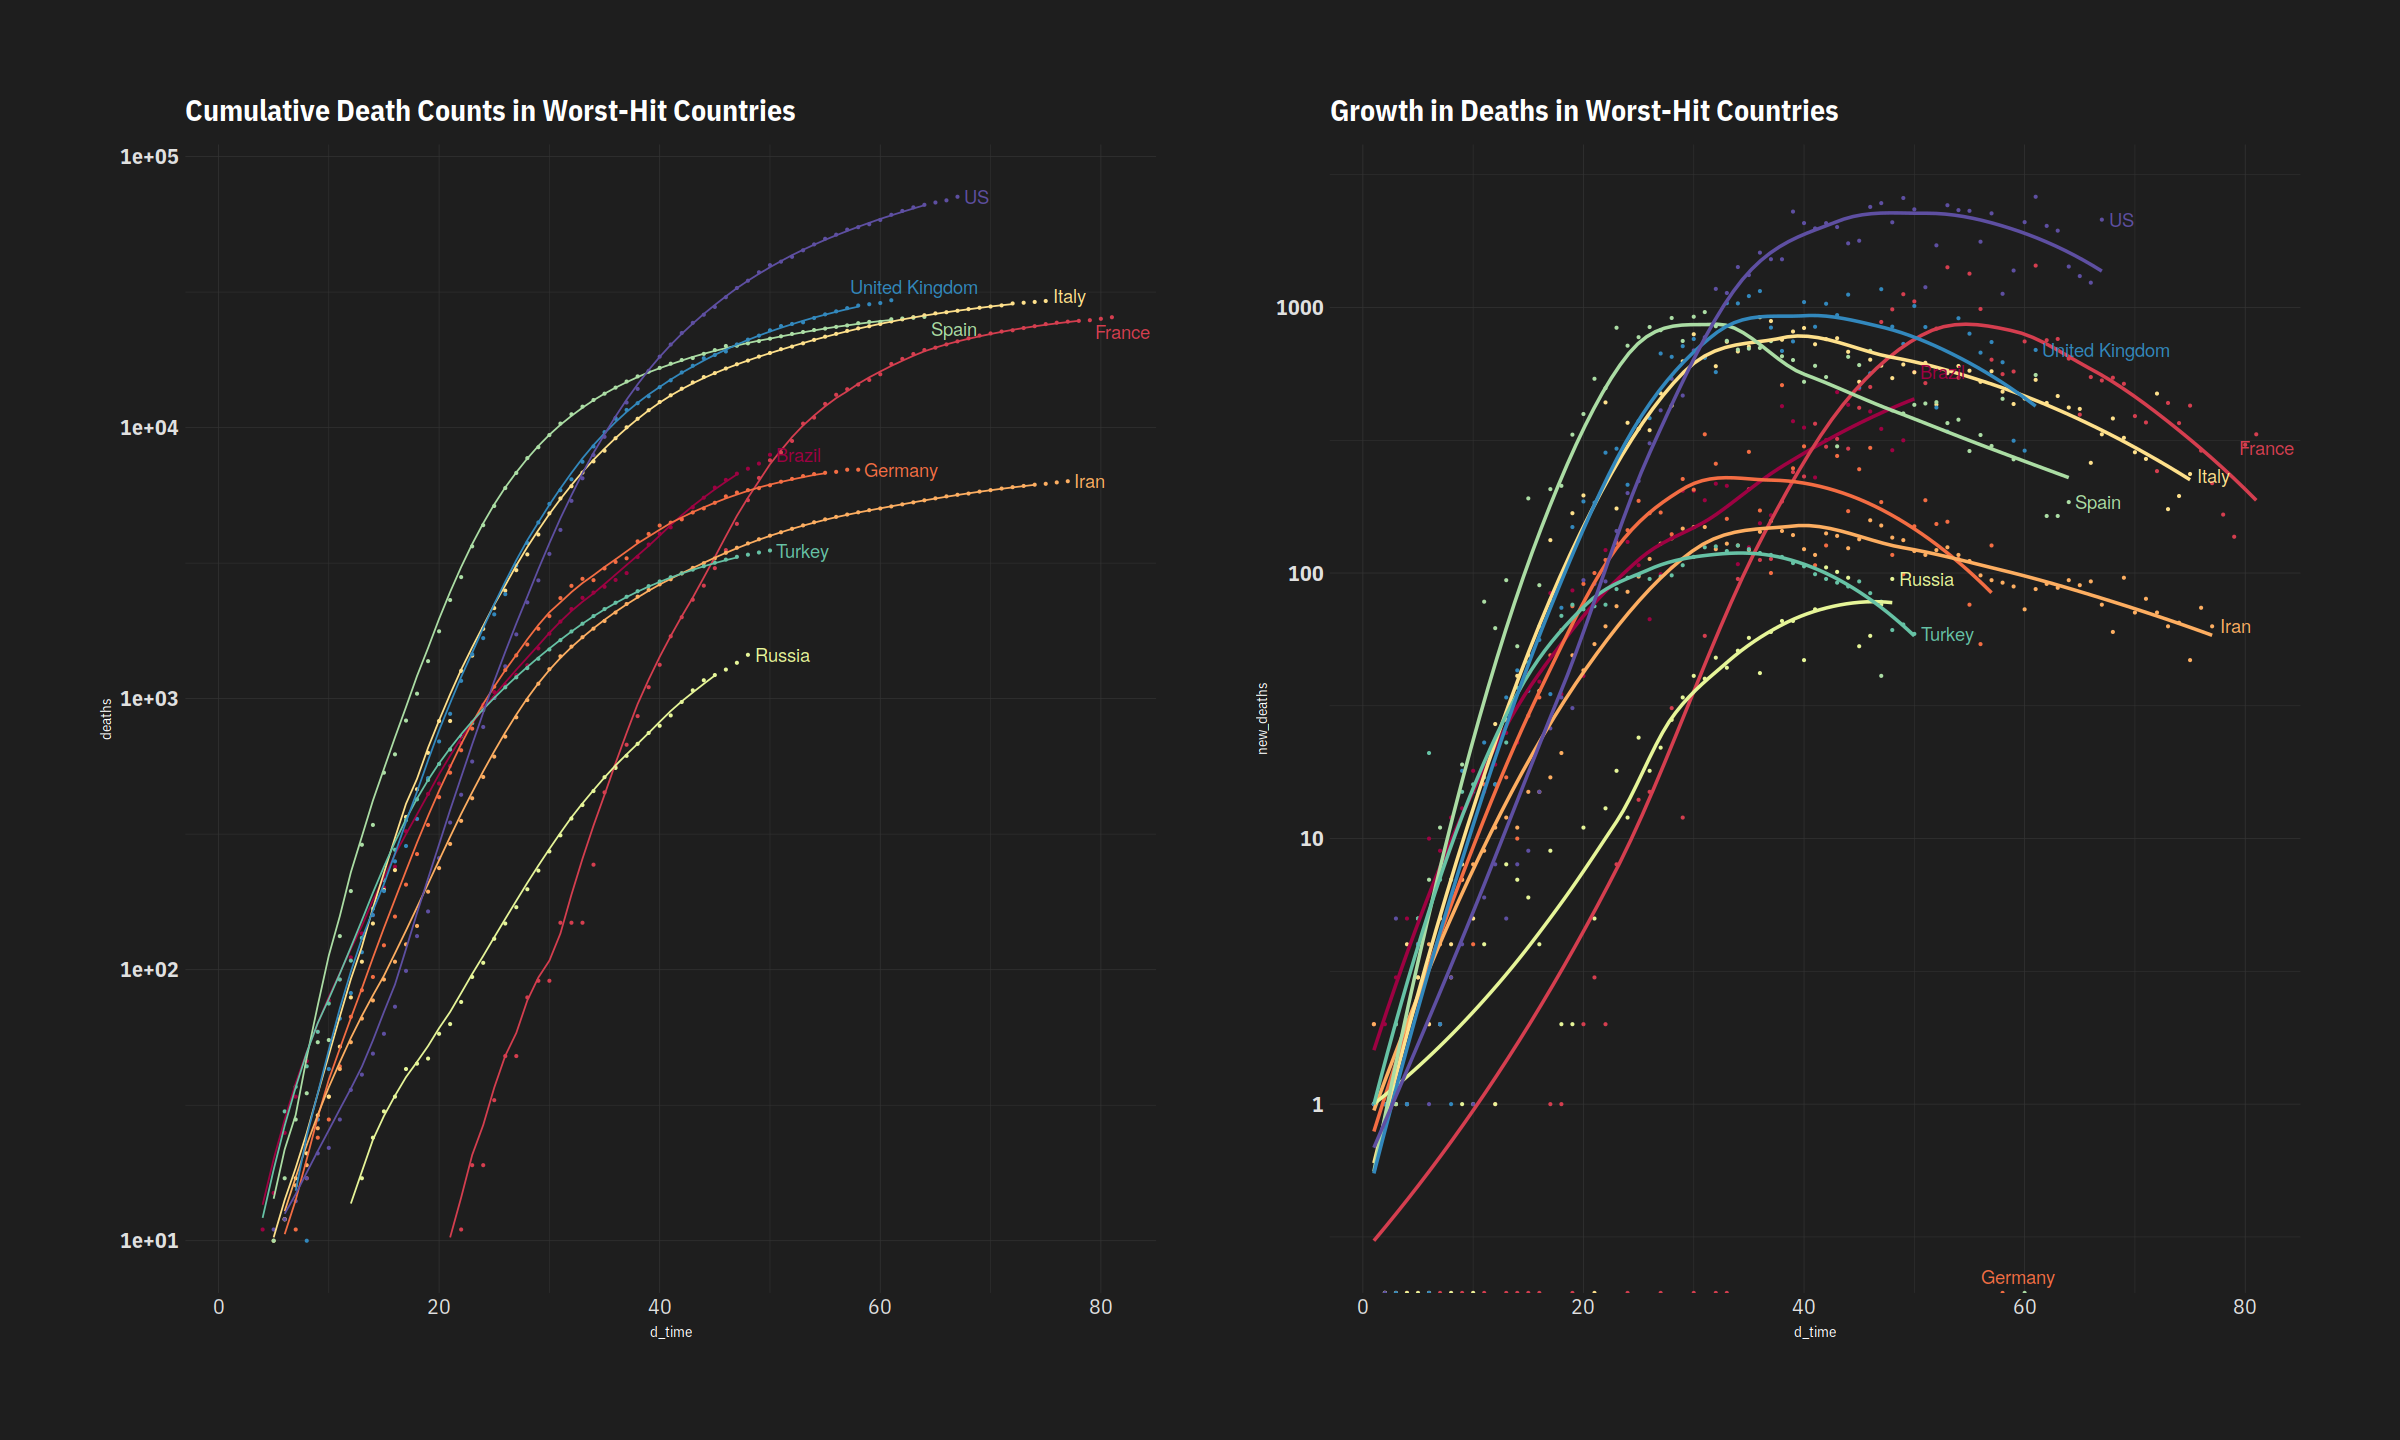

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 421 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 421 rows containing missing values (geom_point).”


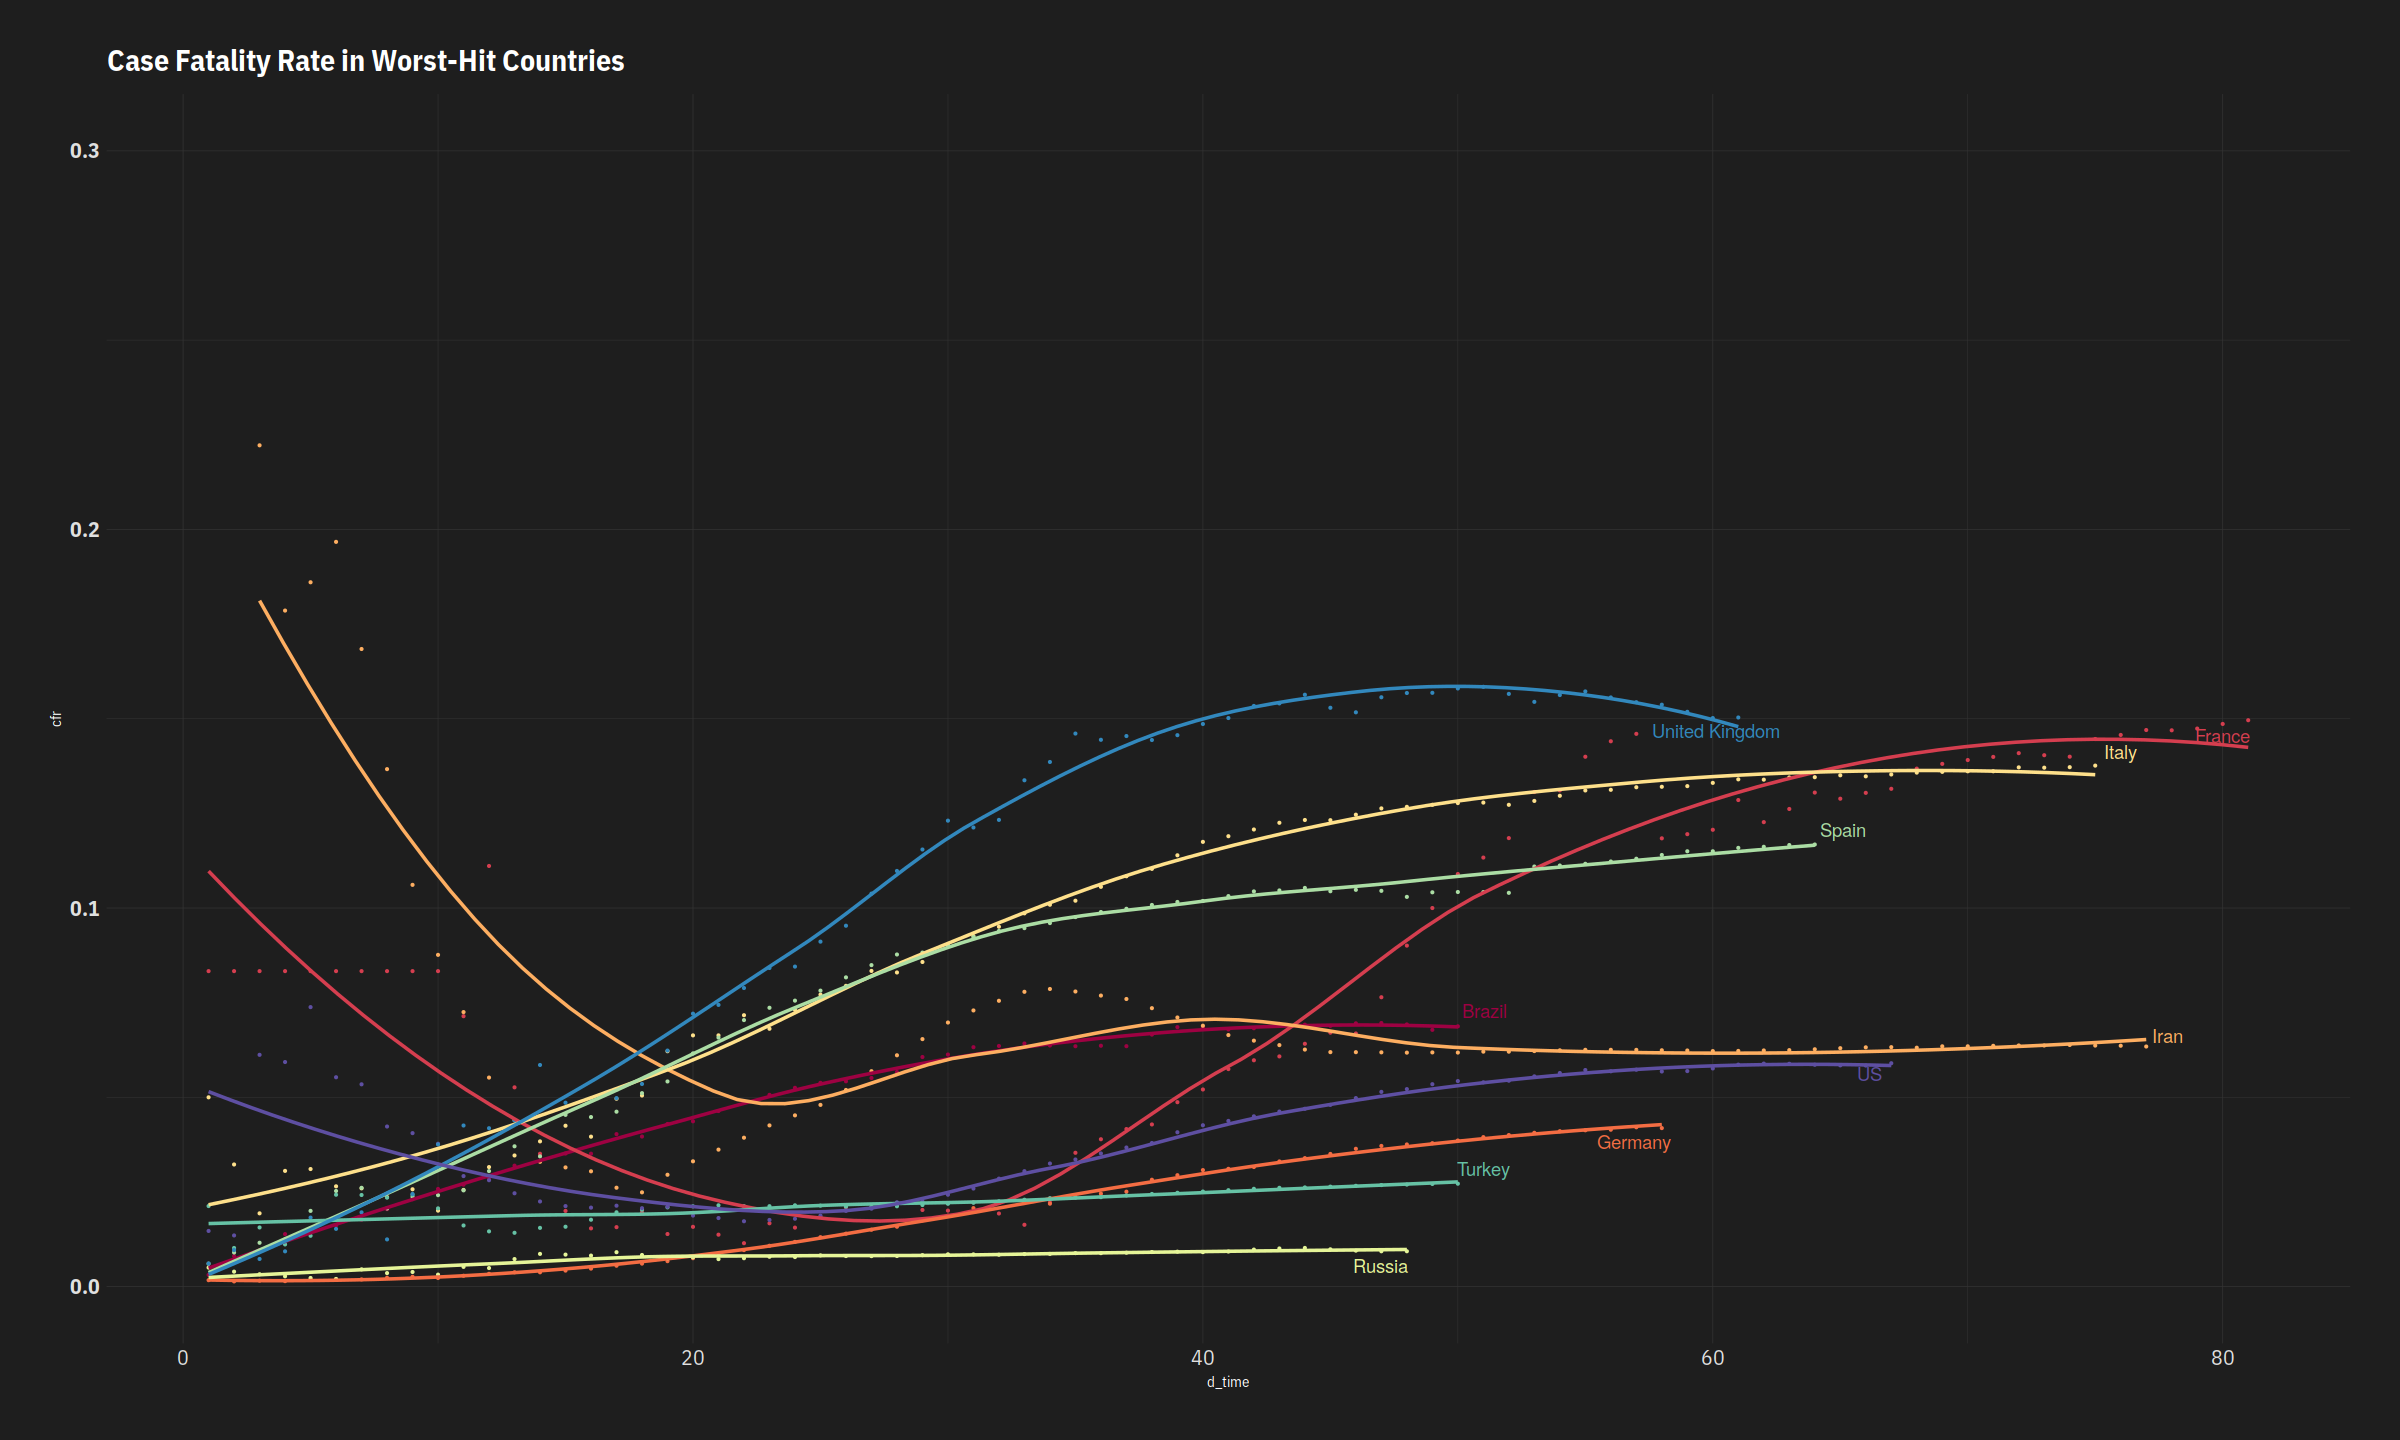

In [17]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    ggtitle('Case Fatality Rate in Worst-Hit Countries')
p3

## Shares

In [15]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 30 rows containing missing values (position_stack).”


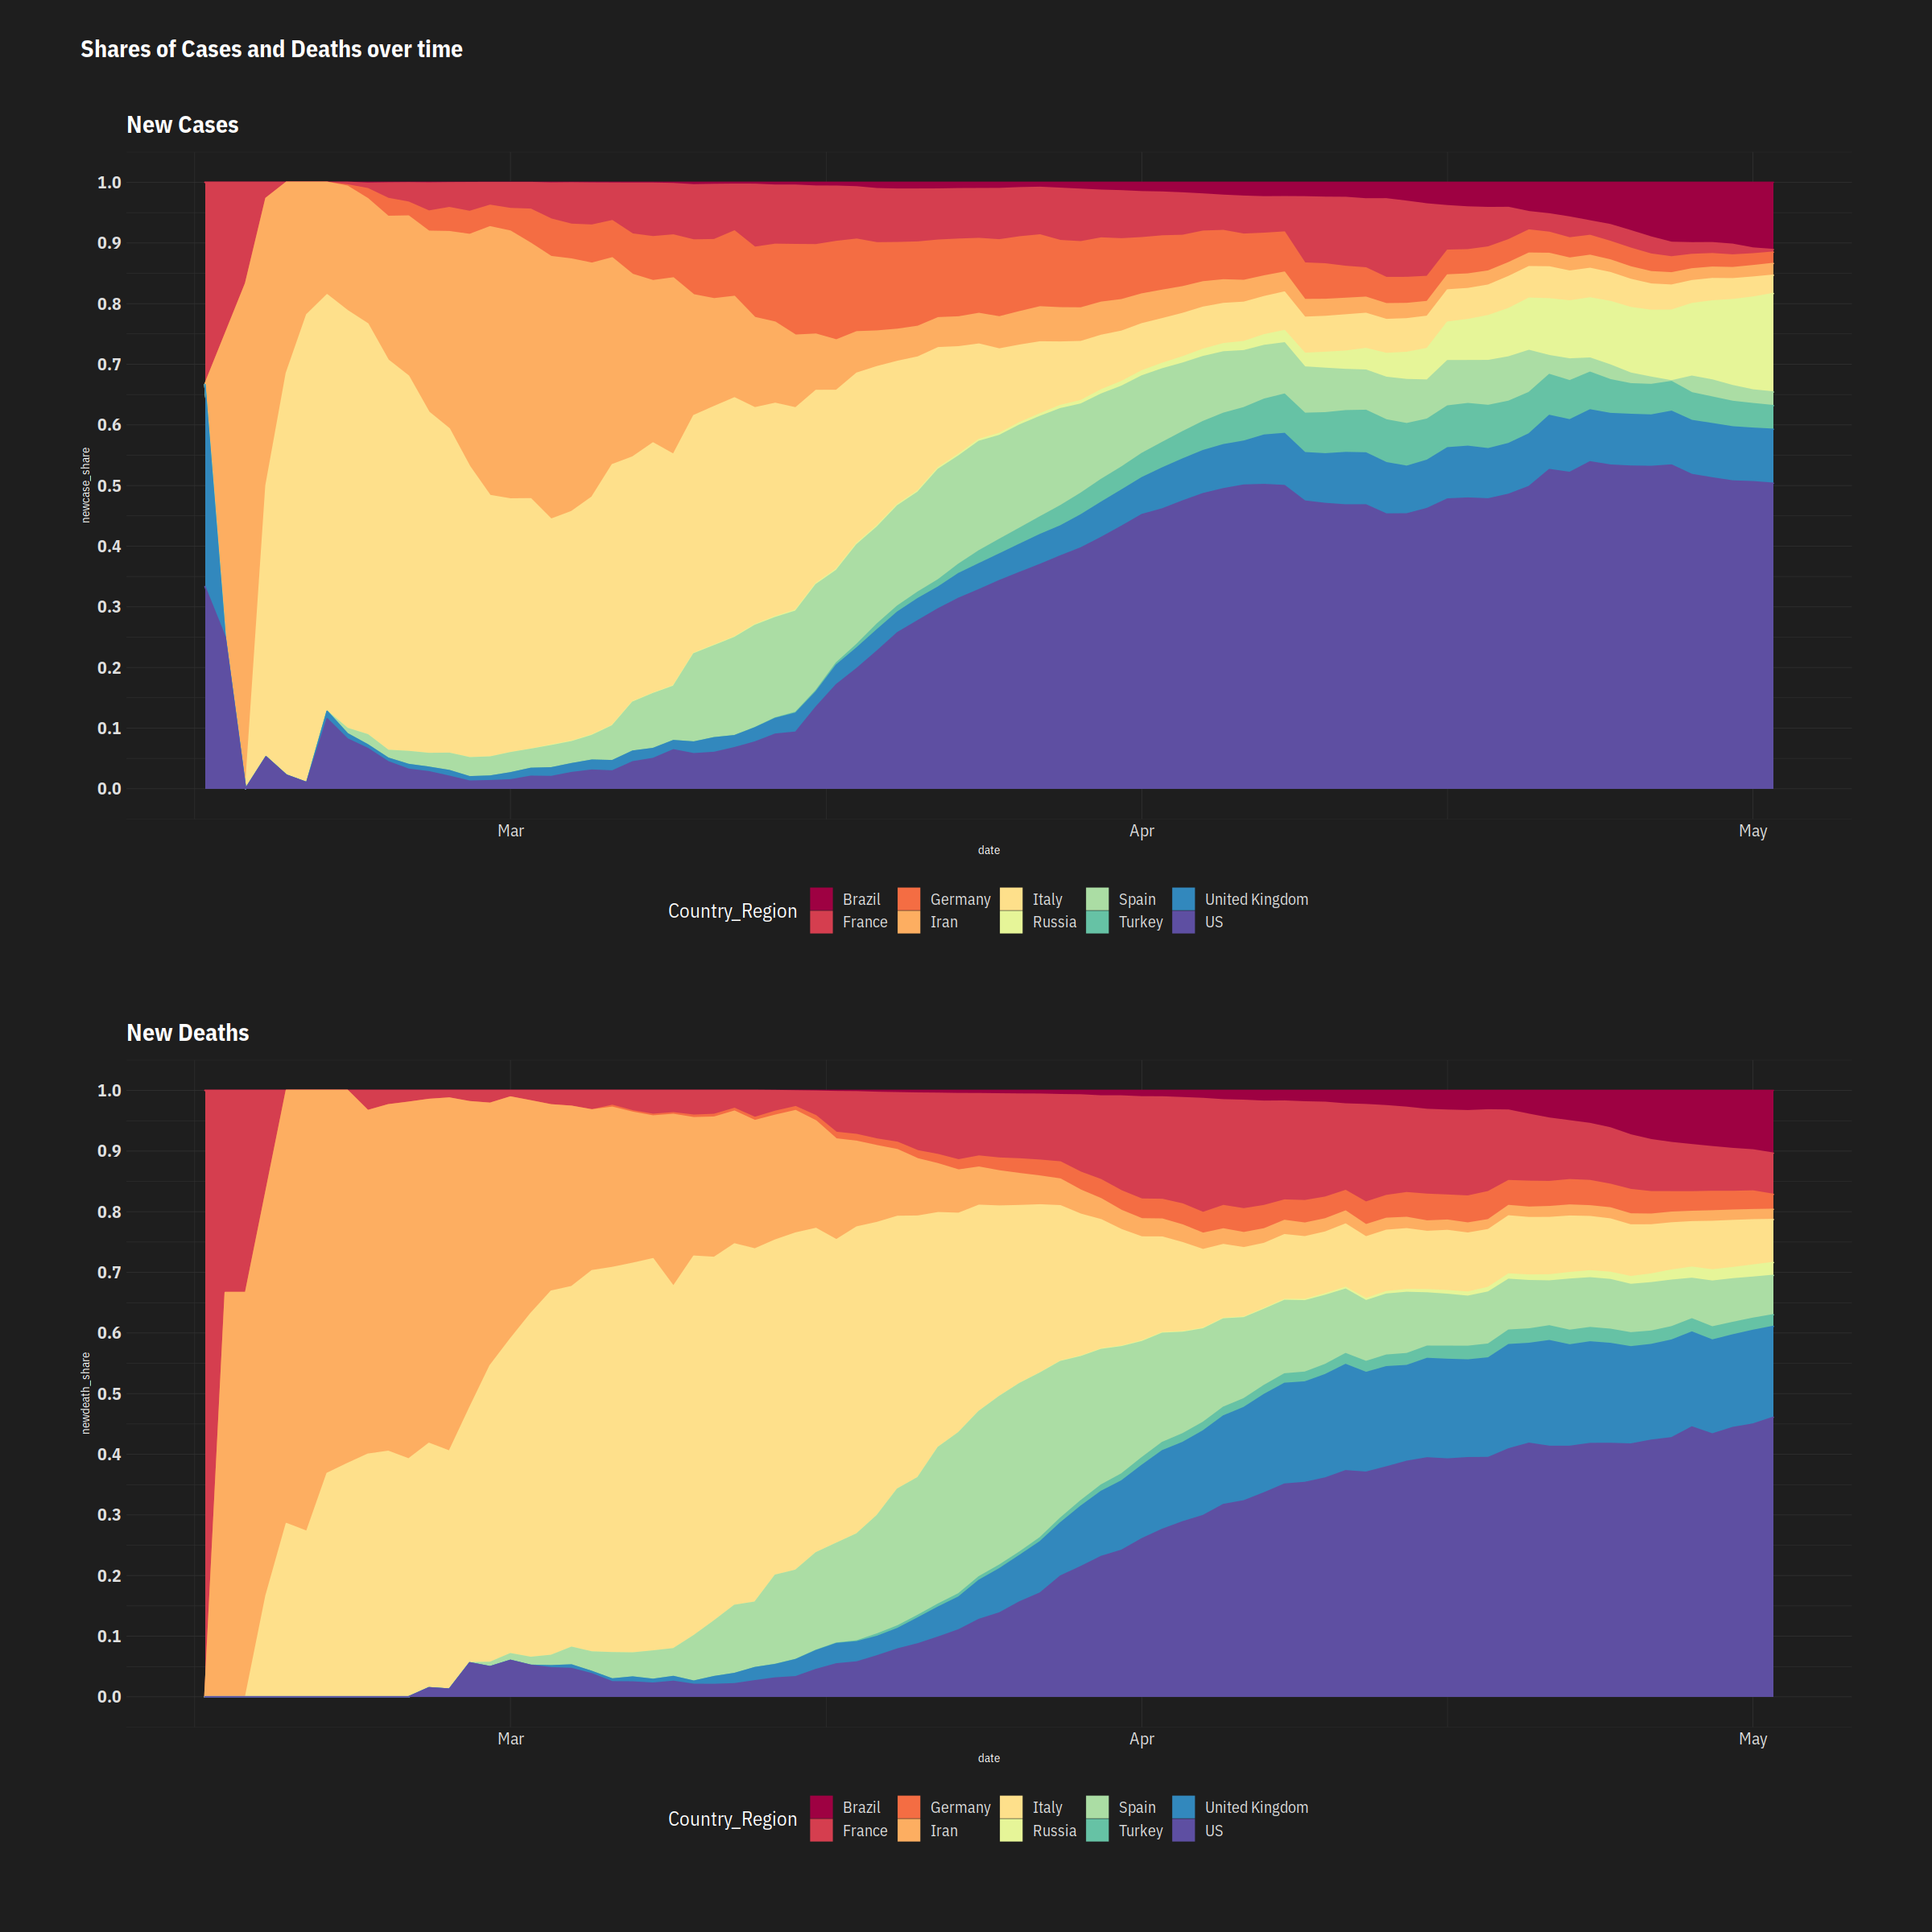

In [23]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 20)
(p1 / p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

In [17]:
df[Province_State != "", unique(Country_Region)]

[1] "Canada"         "United Kingdom" "China"          "Netherlands"   
[5] "Australia"      "Denmark"        "France"

# OWID 

In [24]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 15,338
Columns: 17
$ iso_code                 <chr> "ABW", "ABW", "ABW", "ABW", "ABW", "ABW", "A…
$ location                 <chr> "Aruba", "Aruba", "Aruba", "Aruba", "Aruba",…
$ date                     <chr> "2020-03-13", "2020-03-20", "2020-03-24", "2…
$ total_cases              <int> 2, 4, 12, 17, 19, 28, 28, 28, 50, 55, 55, 60…
$ new_cases                <int> 2, 2, 8, 5, 2, 9, 0, 0, 22, 5, 0, 5, 2, 2, 0…
$ total_deaths             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ new_deaths               <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ total_cases_per_million  <dbl> 18.73, 37.47, 112.39, 159.23, 177.96, 262.26…
$ new_cases_per_million    <dbl> 18.733, 18.733, 74.930, 46.831, 18.733, 84.2…
$ total_deaths_per_million <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.…
$ new_deaths_per_million   <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.…
$ total_tests              <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ new_tests                

In [25]:
(t10 = owid[d == max(d) & location!="World"][order(-total_cases)][1:10])

iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,d
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<date>
USA,United States,2020-05-05,1180634,22593,68934,1252,3566.8,68.256,208.258,3.782,NA,NA,NA,NA,,2020-05-05
ESP,Spain,2020-05-05,218011,545,25428,164,4662.9,11.657,543.859,3.508,NA,NA,NA,NA,,2020-05-05
ITA,Italy,2020-05-05,211938,1221,29079,195,3505.3,20.195,480.948,3.225,2246666,55263,37.158,0.914,tests performed,2020-05-05
GBR,United Kingdom,2020-05-05,190584,3985,28734,288,2807.4,58.701,423.268,4.242,1015138,69839,14.954,1.029,people tested,2020-05-05
DEU,Germany,2020-05-05,163860,685,6831,139,1955.7,8.176,81.531,1.659,NA,NA,NA,NA,,2020-05-05
RUS,Russia,2020-05-05,145268,10581,1356,76,995.4,72.505,9.292,0.521,4460357,157114,30.564,1.077,tests performed,2020-05-05
FRA,France,2020-05-05,131863,576,25201,306,2020.2,8.824,386.083,4.688,NA,NA,NA,NA,,2020-05-05
TUR,Turkey,2020-05-05,127659,1614,3461,64,1513.6,19.137,41.037,0.759,1204421,33283,14.281,0.395,tests performed,2020-05-05
BRA,Brazil,2020-05-05,107780,6633,7321,296,507.1,31.205,34.442,1.393,NA,NA,NA,NA,,2020-05-05


In [26]:
t10[, .(iso_code, total_tests_per_thousand)]

iso_code,total_tests_per_thousand
<chr>,<dbl>
USA,NA
ESP,NA
ITA,37.158
GBR,14.954
DEU,NA
RUS,30.564
FRA,NA
TUR,14.281
BRA,NA


In [33]:
owid_t10_subset = owid[location %in% t10$location]

In [47]:
vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Warning message:
“Removed 36 rows containing missing values (position_stack).”
Warning message:
“Removed 45 rows containing missing values (position_stack).”


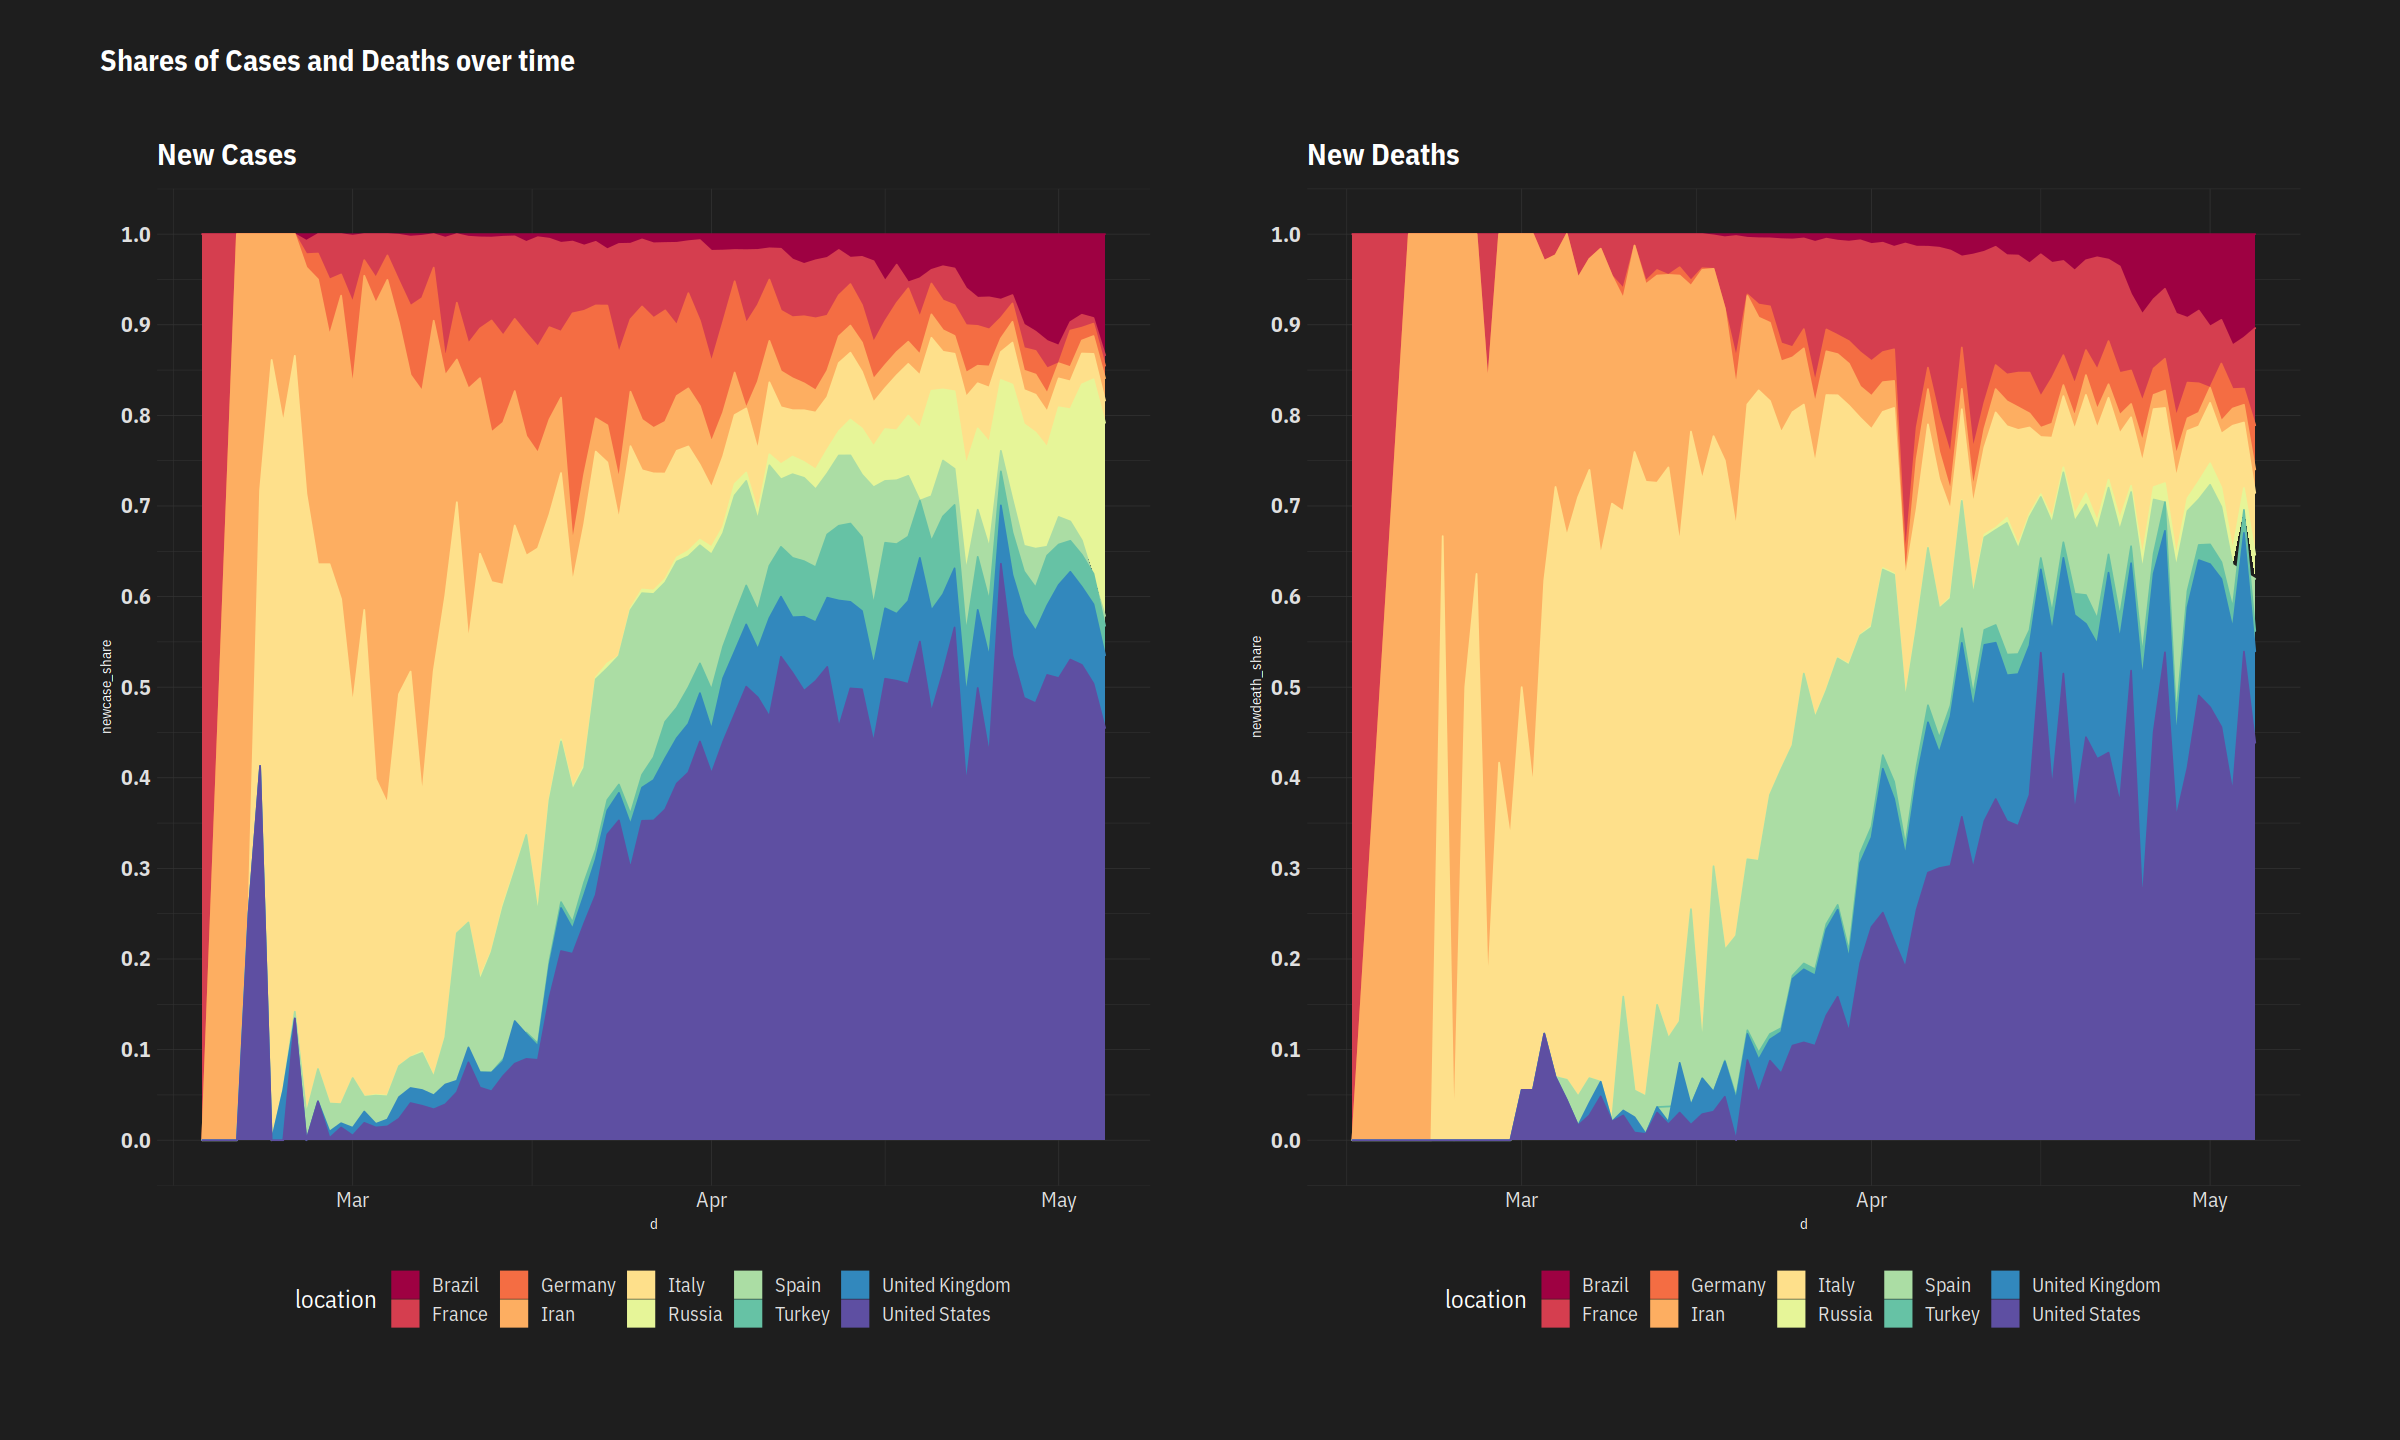

In [48]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")